In [2]:
import numpy as np
from scipy.optimize import minimize

In [5]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [7]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method="nelder-mead",
      options={"xtol": 1e-8, "disp": True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [11]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method="powell",
      options={"xtol": 1e-8, "disp": True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 1622


In [12]:
print(res.x)

[1. 1. 1. 1. 1.]


The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only
function evaluations and is a good choice for simple minimization problems. However, because it does not use any
gradient evaluations, it may take longer to find the minimize.

Another optimization algorithm that needs only function calls to find the minimum is Powell‘s method available by
setting method=’powell’ in minimize.

## Broyden-Fletcher-Goldfarb-Shanno algorithm (method=’BFGS’)

In order to converge more quickly to the solution, this routine uses the gradient of the objective function. If the gradient
is not given by the user, then it is estimated using first-differences. The Broyden-Fletcher-Goldfarb-Shanno (BFGS)
method typically requires fewer function calls than the simplex algorithm even when the gradient must be estimated.
To demonstrate this algorithm, the Rosenbrock function is again used. The gradient of the Rosenbrock function is the
vector:
∂f
∂xj
=
X
N
i=1
200
xi − x
2
i−1

(δi,j − 2xi−1δi−1,j ) − 2 (1 − xi−1) δi−1,j .
= 200
xj − x
2
j−1

− 400xj

xj+1 − x
2
j

− 2 (1 − xj ).
This expression is valid for the interior derivatives. Special cases are
∂f
∂x0
= −400x0

x1 − x
2
0

− 2 (1 − x0),
∂f
∂xN−1
= 200
xN−1 − x
2
N−2

In [13]:
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [14]:

res = minimize(rosen, x0, method="BFGS", jac=rosen_der,
options={"disp": True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


In [15]:
print(res.x)

[1.00000004 1.0000001  1.00000021 1.00000044 1.00000092]


## Newton-Conjugate-Gradient algorithm (method=’Newton-CG’)

The method which requires the fewest function calls and is therefore often the fastest method to minimize functions
of many variables uses the Newton-Conjugate Gradient algorithm. This method is a modified Newton’s method and
uses a conjugate gradient algorithm to (approximately) invert the local Hessian. Newton’s method is based on fitting
the function locally to a quadratic form:


In [17]:
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

In [19]:
res = minimize(rosen, x0, method="Newton-CG",
jac=rosen_der, hess=rosen_hess,
options={"avextol": 1e-8, "disp": True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 50
         Hessian evaluations: 21


/home/atul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: avextol
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
print(res.x)

[0.9999852  0.9999705  0.99994098 0.99988173 0.99976293]


In [27]:
def rosen_hess_p(x,p):
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1]- 400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

In [30]:
res = minimize(rosen, x0, method="Newton-CG",
jac=rosen_der, hessp=rosen_hess_p,
options={"avextol": 1e-8, "disp": True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 50
         Hessian evaluations: 51


/home/atul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: avextol
  This is separate from the ipykernel package so we can avoid doing imports until


##  1.5.2 Constrained minimization of multivariate scalar functions (minimize)

allows to deal with constrained minimization problems of the form:
min F(x)
subject to Cj (X) = 0, j = 1, ..., MEQ
Cj (x) ≥ 0, j = MEQ + 1, ..., M
XL ≤ x ≤ XU, I = 1, ..., N.
As an example, let us consider the problem of maximizing the function:
f(x, y) = 2xy + 2x − x
2 − 2y
2
subject to an equality and an inequality constraints defined as:
x
3 − y = 0
y − 1 ≥ 0
The objective function and its derivative are defined as follows.

In [32]:
def func(x, sign=1.0):
    """ Objective function """
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)
def func_deriv(x, sign=1.0):
    """ Derivative of objective function """
    dfdx0 = sign*(-2*x[0] + 2*x[1] + 2)
    dfdx1 = sign*(2*x[0] - 4*x[1])
    return np.array([ dfdx0, dfdx1 ])

In [33]:
cons = ({"type": "eq",
 "fun" : lambda x: np.array([x[0]**3 - x[1]]),
 "jac" : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
 {"type": "ineq",
 "fun" : lambda x: np.array([x[1] - 1]),
 "jac" : lambda x: np.array([0.0, 1.0])})

In [34]:
res = minimize(func, [-1.0,1.0], args=(-1.0,), jac=func_deriv,
   method="SLSQP", options={"disp": True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4


In [35]:
print(res.x)

[2. 1.]


In [37]:
res = minimize(func, [-1.0,1.0], args=(-1.0,), jac=func_deriv,
constraints=cons, method="SLSQP", options={"disp": True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.0000001831052137
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9


In [38]:
print(res.x)

[1.00000009 1.        ]


## 1.5.3 Least-square fitting (leastsq)

In [39]:
from numpy import *
x = arange(0,6e-2,6e-2/30)
A,k,theta = 10, 1.0/3e-2, pi/6
y_true = A*sin(2*pi*k*x+theta)
y_meas = y_true + 2*random.randn(len(x))
def residuals(p, y, x):
    A,k,theta = p
    err = y-A*sin(2*pi*k*x+theta)
    return err
def peval(x, p):
    return p[0]*sin(2*pi*p[1]*x+p[2])
p0 = [8, 1/2.3e-2, pi/3]

from scipy.optimize import leastsq
plsq = leastsq(residuals, p0, args=(y_meas, x))
print(plsq[0])


[-9.91384476 33.20444498  3.65401655]


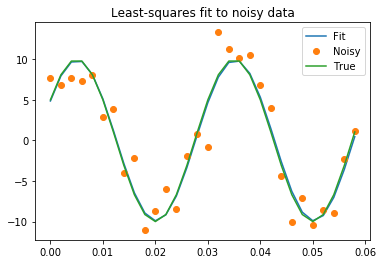

In [41]:
import matplotlib.pyplot as plt
plt.plot(x,peval(x,plsq[0]),x,y_meas,'o',x,y_true)
plt.title('Least-squares fit to noisy data')
plt.legend(['Fit', 'Noisy', 'True'])
plt.show()

## 1.5.4 Univariate function minimizers (minimize_scalar)

Unconstrained minimization (method=’brent’)

In [44]:
from scipy.optimize import minimize_scalar
f = lambda x: (x - 2) * (x + 1)**2
res = minimize_scalar(f, method="brent")
print(res.x)

1.0


Bounded minimization (method=’bounded’)

In [47]:
from scipy.special import j1
res = minimize_scalar(j1, bounds=(4, 7), method="bounded")
print(res.x)

5.3314418424098315


## Root finding

In [48]:
import numpy as np
from scipy.optimize import root
def func(x):
    return x + 2 * np.cos(x)
sol = root(func, 0.3)
sol.x

array([-1.02986653])

In [52]:
def func2(x):
    f = [x[0] * np.cos(x[1]) - 4,
    x[1]*x[0] - x[1] - 5]
    df = np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])],
    [x[1], x[0] - 1]])
    return f, df
sol = root(func2, [1, 1], jac=True, method="lm")
sol.x

array([6.50409711, 0.90841421])